# Assignment 1

__Name__: __Zhi Li__           
__OU ID__: __113523595__

In [1]:
from netCDF4 import Dataset, num2date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from netCDF4 import Dataset,num2date
from datetime import datetime
from dateutil.rrule import rrule, MONTHLY
from scipy import stats
from mpl_toolkits.basemap import Basemap,maskoceans,interp,shiftgrid
import scipy
from scipy.integrate import quad
import sys
sys.path.append('/Users/allen/Documents/Python/PlotGallary')

from matplotlibconfig import basic

#configure plot
basic()

In [102]:
# some utility functions

def visualize(lon, lat, data, stipple=None, **figkwargs):
    """
    Args:
    ---------------
    :figkwargs - dict; {
                        'ylabel': '',
                        'cmap': 'seismic',
                        'cRange': (-1,1),
                        'title': '',
                        'extent': tuple; (llclon, llclat, urclon, urclat)
                        'projection': str; default 'npstere'
                        }
    """å
    
    ylabel= figkwargs.get('ylabel', '')
    cmapName= figkwargs.get('cmap', 'seismic')
    cRange= figkwargs.get('cRange', (-1,1))
    title= figkwargs.get('title', '')
    lllon, lllat, urlon, urlat= figkwargs.get('extent', (-180, -90, 180, 90))
    proj= figkwargs.get('projection', 'npstere')
    
    if proj!='npstere':
        rnd= False
    else: rnd=True
    
    
    cmin = cRange[0]; cmax = cRange[1];
    cint = 0.2; clevs = np.round(np.arange(cmin,cmax,cint),1)
    nlevs = len(clevs)-1
    
    plt.gca()
    cmap = plt.get_cmap(name= cmapName,lut=nlevs) 
    m = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat,
                projection=proj, lon_0=-100, boundinglat=20, round=rnd)
    
    x,y = m(lon,lat)
    m.drawcoastlines(linewidth=3)
    m.drawmapboundary(linewidth=2)
#     m.drawmeridians(range(-90, 90, 10))
#     m.drawparallels(range(-180, 180, 20))
    if stipple is not None:
        m.plot(x[stipple][::3],y[stipple][::3],'o',color='Gold',markersize=1.5) #
    cs = m.contourf(x, y, data)
    cbar = m.colorbar(cs)
    cbar.ax.set_ylabel(ylabel) 
    plt.title(title,name='Arial',weight='bold',size=20)
    
    return m

## Question 1

This problem examines the statistical relationship between 500 hPa heights and the El Niño-Southern
Oscillation (ENSO) during boreal winter (December, January and February). For this question, you will use
two files: (1) ENSO.txt, which contains monthly-mean standardized values of an index measuring ENSO
strength and (2) Z500.nc, which contains gridded monthly-mean 500 hPa geopoten􀆟al heights globally from
1950 - 2019. The steps for the analysis and final product will be as follows:

In [113]:
# read in geopotential heights data
with Dataset('GPH500.nc', 'r') as nc:
    lonHeights= np.array(nc.variables['lon'][:])
    latHeights= np.array(nc.variables['lat'][:])
    time= nc.variables['time'][:]
    timeUnits= nc.variables['time'].units
    heightDate= num2date(time, timeUnits, calendar='standard')
    heightMonth= np.array([date.month for date in heightDate])
    heightYear= np.array([date.year for date in heightDate])
    heights= np.array(nc.variables['hgt'][:])
    

In [114]:
heights[heights<0]= np.nan

In [115]:
# read in ENSO data
ENSOfile= np.loadtxt('ENSO.txt', skiprows=2)
ENSOyear= ENSOfile[:,0]
ENSOmonth= ENSOfile[:,1]
ENSO= ENSOfile[:,2]


1. Calculate 500 hPa height anomalies, use the 1981 – 2010 base period as your climatology / mean.

In [116]:
# select monthly height from 1981 to 2010
indices= np.where((heightYear>=1981) & (heightYear<=2010))
# compute the climatology and corresponding date
anoHeights= heights - np.nanmean(heights[indices], axis=0)

2. Calculate the Dec - Feb mean 500 hPa geopotential height anomaly field and ENSO index from each complete winter season in the dataset

In [117]:
# subselect DJF anomalies and corresponding date
anoIndex= np.where((ENSOmonth==12) | (ENSOmonth==1) | (ENSOmonth==2))
anoHeights= anoHeights[anoIndex]
ENSO= ENSO[anoIndex]

In [118]:
posENSO= ENSO[ENSO>= np.std(ENSO)]
negENSO= ENSO[ENSO<= -np.std(ENSO)]

posIndex= np.where(ENSO>= np.std(ENSO))
negIndex= np.where(ENSO<= -np.std(ENSO))

3. Generate composite DJF-mean 500 hPa height anomaly plots for times when ENSO index exceeds 1$\sigma$ and exceeds -1$\sigma$. Use shaded contours for plotting.

In [119]:
posComp= anoHeights[posIndex]
negComp= anoHeights[negIndex]

In [120]:
posCompMean= np.array(posComp).mean(axis=0)
negCompMean= np.array(negComp).mean(axis=0)

In [121]:
lons, lats= np.meshgrid(lonHeights, latHeights)

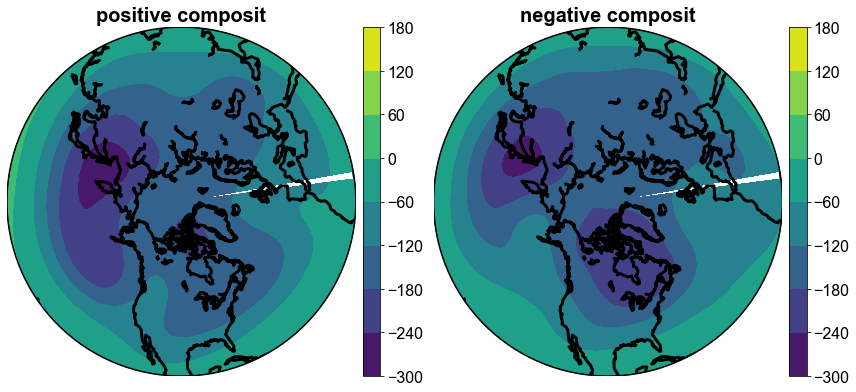

In [122]:
fig= plt.figure(figsize=(12,8))
ax1= fig.add_subplot(121)
map= visualize(lons, lats, posCompMean, title='positive composit')
ax2= fig.add_subplot(122)
map= visualize(lons, lats, negCompMean,  title='negative composit')

4. Compute the composite difference. Identify regions where the composite difference is significant at the p<0.1 level using either a t-test or a Monte Carlo test. Consider each event as a degree of freedom for the calculation. Outline or stipple these significant regions on the composite difference plot

In [123]:
compDiff= posCompMean- negCompMean

In [124]:
# t-statistics evaluation

n1 = len(posENSO) 
n2 = len(negENSO) 
dof = n1+n2-2 

s1 = np.std(posComp, axis=0) 
s2 = np.std(negComp, axis=0) 
sigma = ((n1*s1**2+n2*s2**2)/(n1+n2-1))**.5

tStatistic = compDiff/sigma/((1/n1+1/n2)**.5)

pval = 2*stats.t.cdf(-abs(tStatistic),dof*np.ones(tStatistic.shape))


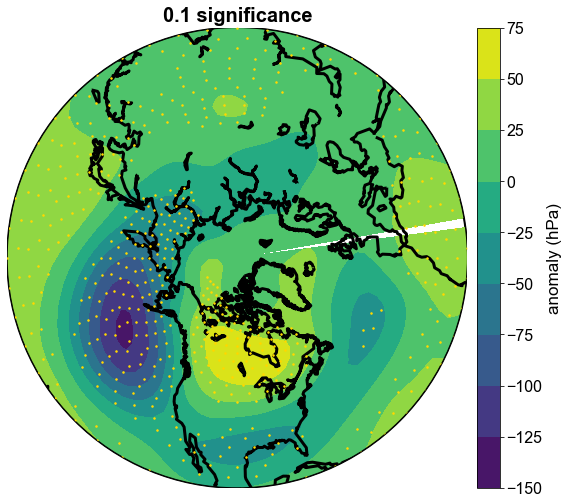

In [127]:
alpha= 0.1
stipple= pval<=alpha

fig= plt.figure(figsize=(8,8))
ax= fig.add_subplot(111)
map= visualize(lons, lats, compDiff, stipple, title='0.1 significance',
               ylabel='anomaly (hPa)')

In [128]:
#=========================================================================
# Calculate significance using Monte Carlo testing. Do this on a per point basis.
#=========================================================================
# select monthly height from 1981 to 2010
indices= np.where((heightYear>=1981) & (heightYear<=2010))

ano= heights - np.nanmean(heights[indices], axis=0)

ENSO= ENSOfile[:,2]
posENSO= ENSO[ENSO>= np.std(ENSO)]
negENSO= ENSO[ENSO<= -np.std(ENSO)]
T,J,I = ano.shape
niter = 6000
djf = np.where( (ENSOmonth>=12) | (ENSOmonth<=2) )[0]
y = ano.reshape(T,J*I, order='F')
mcCompDiff = np.ones((niter,y.shape[-1]))*np.nan

for n in range(niter):
    c1 = np.random.choice(djf, len(posComp), replace=False)
    c2 = np.random.choice(djf, len(negComp), replace=False)
    mcPos = np.nanmean(y[c1,:],0)
    mcNeg = np.nanmean(y[c2,:],0)
    mcCompDiff[n,:] = mcPos-mcNeg

# Calculate the pvalue for each point
c12 = compDiff.reshape(J*I,order='F')
pval = np.array([stats.percentileofscore(mcCompDiff[:,i],c12[i])/100. 
                 for i in range(c12.size)])

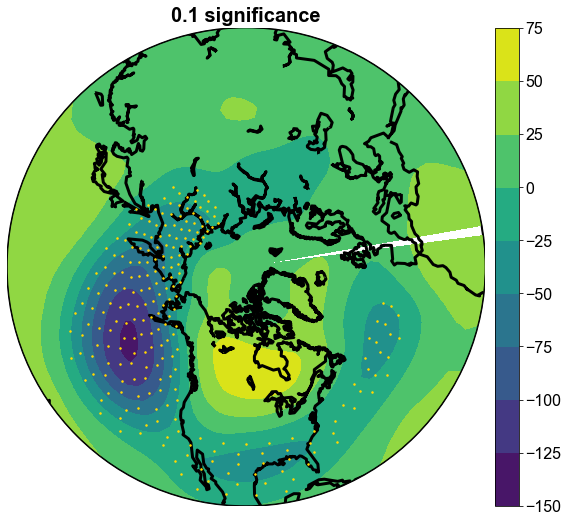

In [129]:
alpha= 0.1
stipple= pval<=alpha

fig= plt.figure(figsize=(8,8))
ax= fig.add_subplot(111)
map= visualize(lons, lats, compDiff, stipple.reshape(lons.shape, order='F'),
               title='0.1 significance')

5. Assemble the plots for presentation as a 3-panel plot, with the positive ENSO composite on top, the
negative ENSO composite in the middle, and the composite difference on the bottom. Make the plot
only for the Northern Hemisphere (i.e., 20-90 N).

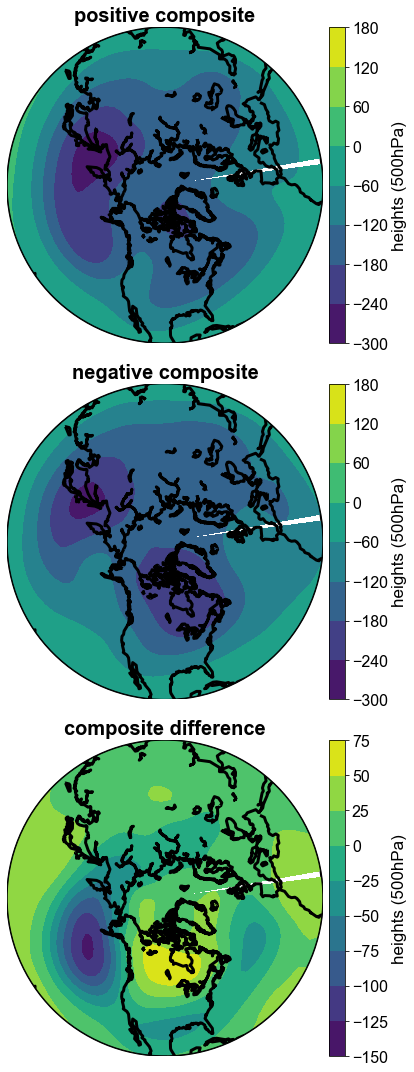

In [134]:
fig= plt.figure(figsize=(6,15))
ax= fig.add_subplot(311)
map= visualize(lons, lats, posCompMean, extent=(-180,20,180,90),
               title='positive composite', ylabel='heights (500hPa)')
ax= fig.add_subplot(312)
map= visualize(lons, lats, negCompMean, extent=(-180,20,180,90),
               title='negative composite', ylabel='heights (500hPa)')
ax= fig.add_subplot(313)
map= visualize(lons, lats, compDiff, extent=(-180,20,180,90),
               title='composite difference', ylabel='heights (500hPa)')
plt.tight_layout()

As from the significance test, both the t-test and Monte-Carlo test show that the differences of geopotential heights for positive ENSO and negative ENSO are significant in North Pacific Ocean, southern U.S., and part of North Atlantic Ocean. In these areas, the difference is significantly skewed towards negative, which indicates the negative ENSO indicator strongly affect this extratropical places, especially decreasing the 500 hPa geopotential height. As a consequence, this impact will change the global weather pattern (i.e., influence the precipitation distribution).

There are some differences between t-test and Monte-Carlo simulation as well. we can see the t-test result (stipples) cover more areas in the globe, suggesting the ENSO factors (positive and negative) have more places under significant differences. 

## Question 2

In [231]:
import pandas as pd

In [247]:
precip= pd.read_csv('BostonMaxDailyPrecip.txt', sep='\t+', skiprows=2, header=None)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [248]:
precip.columns= ['precipInch', 'date', 'precipMM']

In [252]:
precip.date= pd.to_datetime(precip.date)

1. Using the data provided, fit a Gumbel distribution to the Boston precipitation data in mm. Use the methods
of moments to estimate the parameters for the distribution.

$$Gumbel=\frac{1}{\beta}exp(-exp(-\frac{x-\eta}{\beta})-\frac{x-\eta}{\beta})$$

In [269]:
def gumbel(x, eta, beta):
    pdf= 1/beta*np.exp(-np.exp(-(x-eta)/beta)-(x-eta)/beta)
    
    return pdf

def est_beta(x):
    return np.std(x)*6**.5/np.pi

def est_eta(x, beta):
    return x.mean()-0.5772*beta

In [270]:
beta= est_beta(precip.precipMM)
eta= est_eta(precip.precipMM, beta)

In [272]:
print('estimated beta and eta are: %.2f, %.2f'%(beta, eta))

estimated beta and eta are: 20.17, 57.88


In [273]:
gumbel_pdf= gumbel(precip.precipMM, eta, beta)

2. Make a plot with a histogram of the annual daily-maximum precipitation (in mm) and the fitted Gumbel
distribution overlaid on the histogram. On your plot, indicate the values of $\beta$ and $\eta$ used for the fit.

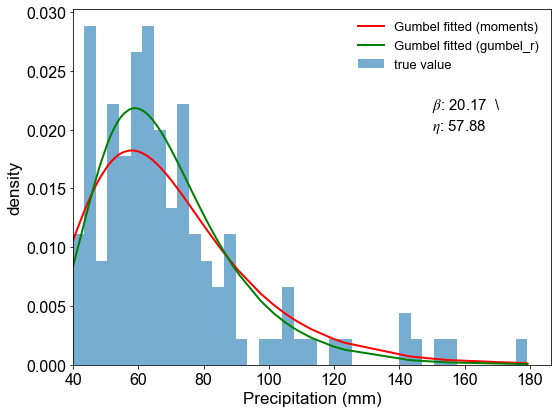

In [425]:
fig, ax= plt.subplots(1,1, figsize=(8,6))
ax.hist(precip.precipMM, bins=40, density=True, label='true value', alpha=.6);
ax.plot(sorted(precip.precipMM), gumbel_pdf[np.argsort(precip.precipMM)],
        c='r', label='Gumbel fitted (moments)')
ax.plot(sorted(precip.precipMM), gumbel_r.pdf(precip.precipMM,loc,scale)[np.argsort(precip.precipMM)],
        color='g', label='Gumbel fitted (gumbel_r)')
ax.set_xlim([40, None])
ax.legend(frameon=False)
ax.set_xlabel('Precipitation (mm)')
ax.set_ylabel('density')
ax.text(150,0.02, r'$\beta$: %.2f  \
$\eta$: %.2f'%(beta, eta));

3. Using your fitted distribution, determine what the probability is that Boston will experience a year with
a daily maximum precipitation amount (i) greater than 130 mm (about 5 in) and (ii) less than 50 mm (about
2 in).

$$P(x>=130)=\int_{130}^{+\inf}pdf(x)dx$$


$$P(x<=50)=\int_{0}^{50}pdf(x)dx$$

In [430]:
func= lambda x: gumbel(x, eta, beta)
prob, err= quad(func, 130, np.inf)
print('The probability exceeds 130 mm from Gumbel function is %.2f, with numerical error of 1e-9'%prob)

prob, err= quad(func, 0, 50)
print('The probability blow 50 mm from Gumbel function is %.2f, with numerical error of 5e-9'%prob)

The probability exceeds 130 mm from Gumbel function is 0.03, with numerical error of 1e-9
The probability blow 50 mm from Gumbel function is 0.23, with numerical error of 5e-9


In [431]:
# cross-check the answer with python inner module stats.gumbel_r

from scipy.stats import gumbel_r
loc, scale= gumbel_r.fit(precip.precipMM)
print(r'fitted beta: %.2f, eta: %.2f, the difference is (%.2f, %.2f) for (beta, eta)\
       relative error (%.2f%%, %.2f%%)'%(scale, loc, beta-scale, eta-loc, (beta-scale)/beta*100, (eta-loc)/eta*100))

fitted beta: 16.85, eta: 58.90, the difference is (3.32, -1.02) for (beta, eta)\
       relative error (16.48%, -1.76%)


In [432]:
print('The true probability beyond 130 mm is %.2f, below 50 mm is %.2f'%(
    quad(lambda x: gumbel(x, loc, scale), 130, np.inf)[0], quad(lambda x: gumbel(x, loc, scale), 0, 50)[0]))


The true probability beyond 130 mm is 0.01, below 50 mm is 0.18


4. Calculate the daily maximum precipitation amounts corresponding to a 1-in-50 year, 1-in-100 year, and
1-in-500 year event in Boston.

In [448]:
obj= lambda x: abs(quad(func, x, np.inf)[0]-0.02)
fifty= scipy.optimize.minimize(obj, 100, tol=1e-8).x

In [449]:
obj= lambda x: abs(quad(func, x, np.inf)[0]-0.01)
hundred= scipy.optimize.minimize(obj, 150, tol=1e-8).x

In [450]:
obj= lambda x: abs(quad(func, x, np.inf)[0]-0.002)
fivehundred= scipy.optimize.minimize(obj, 200, tol=1e-8).x

In [451]:
print('The daily maximum precipitation for 1-in-50 year, 1-in-100-year and 1-in-500 year are %.2f mm/day, %.2f mm/day, %.2f mm/day, respectively'%(
fifty, hundred, fivehundred))

The daily maximum precipitation for 1-in-50 year, 1-in-100-year and 1-in-500 year are 136.60 mm/day, 150.68 mm/day, 183.23 mm/day, respectively


In [452]:
print('The true daily maximum precipitation for 1-in-50 year, 1-in-100-year and 1-in-500 year are %.2f mm/day, %.2f mm/day, %.2f mm/day, respectively'%(
gumbel_r.ppf(1-0.02, loc, scale), gumbel_r.ppf(1-0.01, loc, scale), gumbel_r.ppf(1-0.002, loc, scale)))

The true daily maximum precipitation for 1-in-50 year, 1-in-100-year and 1-in-500 year are 124.64 mm/day, 136.41 mm/day, 163.59 mm/day, respectively


## Question 3

A popular topic in wintertime subseasonal and seasonal forecasting is using the state of the stratospheric
polar vortex to make skillful predictions of tropospheric weather regimes. One mode of climate
variability that forecasters seek to predict is the Northern Annular Mode (NAM) in both the stratosphere
and the troposphere. For stratospheric levels, strongly positive (negative) values of the NAM index (e.g.,
NAM at 50 hPa; NAM50) typically mean that the stratospheric polar vortex is stronger (weaker) than normal
i.e., climatological westerlies in the stratosphere are stronger (weaker) than average. In the troposphere,
strongly positive (negative) values of the near-surface NAM index (e.g., NAM at 1000 hPa; NAM1000) indicate
that the mean position of the polar jet stream is more poleward (equatorward) than normal, sugges
ting warmer (colder) than normal temperatures across the Northern Hemisphere mid-latitudes. In this
exercise, you will investigate how the probability density function (PDF) of NAM1000 may change given the
background state of the stratospheric circulation.

In [473]:
# read the data
NAM1000= pd.read_csv('NAM1000.txt', skiprows=2, header=None, sep='\s+', names=['year', 'month', 'day', 'nam'])
NAM50= pd.read_csv('NAM50.txt', skiprows=2, header=None, sep='\s+', names=['year', 'month', 'day', 'nam'])

1. Calculate the clamatological PDF of $NAM_{1000}$ (i.e., all NDJFMA days). Then, on the same plot, overlay two other conditional PDFs:
    
    The PDF of $NAM_{1000}$ for days when $NAM_{50}>+1\sigma$
    
    The PDF of $NAM_{1000}$ for days when $NAM_{50}<-2\sigma$

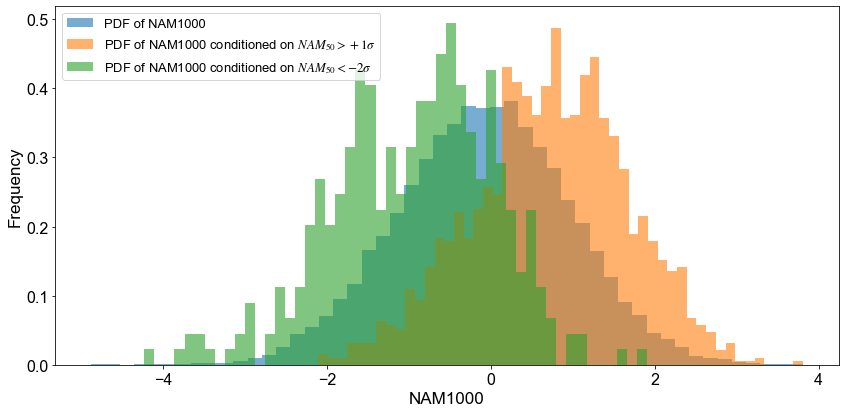

In [503]:
#composite
ndjfma= np.where((NAM1000.month>=11) | (NAM1000.month<=4))[0]

climNAM1000= NAM1000.iloc[ndjfma, :]
climNAM50= NAM50.iloc[ndjfma, :]

posInds= np.where((climNAM50.iloc[:,-1]> np.std(climNAM50.iloc[:,-1])))[0]
negInds= np.where((climNAM50.iloc[:,-1]< -2* np.std(climNAM50.iloc[:,-1])))[0]

posClimNAM1000= climNAM1000.iloc[posInds, -1]
negClimNAM1000= climNAM1000.iloc[negInds, -1]

#make plot
fig, ax= plt.subplots(1,1, figsize=(12,6))
climNAM1000.iloc[:,-1].plot.hist(alpha=.6, bins=50, density=True,label='PDF of NAM1000')
posClimNAM1000.plot.hist(alpha=.6, bins=50, density=True,label='PDF of NAM1000 conditioned on $NAM_{50}>+1\sigma$')
negClimNAM1000.plot.hist(alpha=.6,bins=50, density=True,label='PDF of NAM1000 conditioned on $NAM_{50}<-2\sigma$')
ax.legend()
ax.set_xlabel('NAM1000');

By firstly looking at the distribution for three data, they behave more or less like normal. Thus, we decided to fit into a t-distribution. Then the next thing we need to do is to calibrate those parameters.

Assume the degree of freedom for each case is the sample size.

In [521]:
paramsPos= stats.t.fit(posClimNAM1000.values, len(posClimNAM1000)-1)
paramsNeg= stats.t.fit(negClimNAM1000.values, len(negClimNAM1000)-1)

In [522]:
posDist= stats.t(*paramsPos)
negDist= stats.t(*paramsNeg)

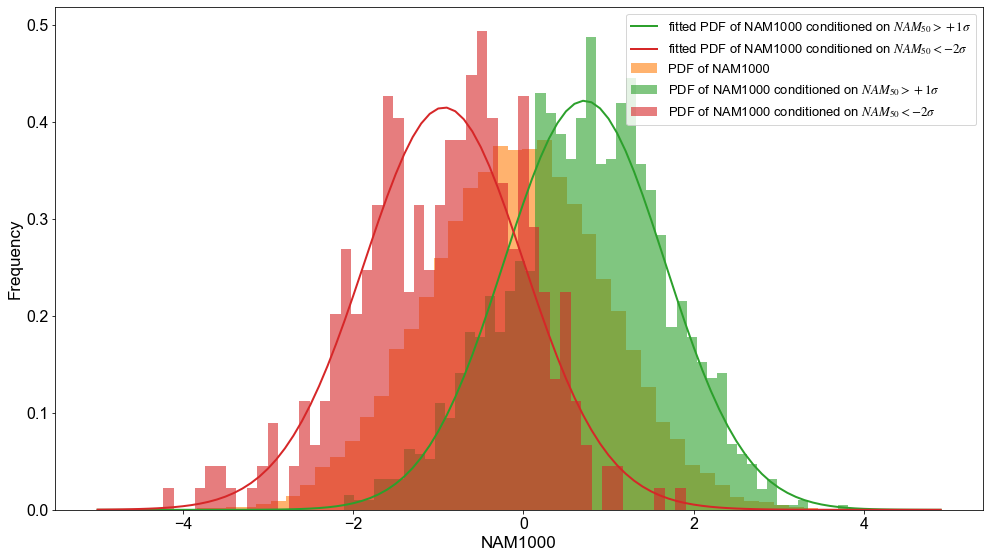

In [532]:
fig, ax= plt.subplots(1,1, figsize=(14,8))
ax.plot(np.arange(-5,5,0.1), posDist.pdf(np.arange(-5,5,0.1)),color= 'C2',
        label='fitted PDF of NAM1000 conditioned on $NAM_{50}>+1\sigma$')
ax.plot(np.arange(-5,5,0.1), negDist.pdf(np.arange(-5,5,0.1)),color= 'C3',
        label='fitted PDF of NAM1000 conditioned on $NAM_{50}<-2\sigma$')
climNAM1000.iloc[:,-1].plot.hist(alpha=.6, bins=50, density=True,
                                 label='PDF of NAM1000', color= 'C1')
posClimNAM1000.plot.hist(alpha=.6, bins=50, density=True, color= 'C2',
                         label='PDF of NAM1000 conditioned on $NAM_{50}>+1\sigma$')
negClimNAM1000.plot.hist(alpha=.6,bins=50, density=True,color= 'C3',
                         label='PDF of NAM1000 conditioned on $NAM_{50}<-2\sigma$')
ax.set_xlabel('NAM1000')
plt.legend();

In [546]:
print('probability that $NAM_{1000}$ smaller than $-1\sigma$ conditioned on $NAM_{50}>+1\sigma$is: %.2f\
      '%(posDist.cdf(-np.std(posClimNAM1000.values))))

probability that $NAM_{1000}$ smaller than $-1\sigma$ conditioned on $NAM_{50}>+1\sigma$is: 0.04      


In [547]:
print('probability that $NAM_{1000}$ smaller than $-1\sigma$ conditioned on $NAM_{50}<-2\sigma$is: %.2f\
      '%(negDist.cdf(-np.std(negClimNAM1000.values))))

probability that $NAM_{1000}$ smaller than $-1\sigma$ conditioned on $NAM_{50}<-2\sigma$is: 0.48      


**K-S test**

In [559]:
stats.ks_2samp(posDist.rvs(size=100), negDist.rvs(size=100))

Ks_2sampResult(statistic=0.63, pvalue=6.314161651442317e-19)

From the K-S test results, we can reject the null hypothesis that two samples are identical with almost 100% confidence.

The $NAM_{50}$ (stratospheric polar vortex) is a good indicator to describe northern hemisphere surface weather since is has distinct behavior (from the PDFs) among positive $NAM_{50}$ and negative $NAM_{50}$. Basically, positive $NAM_{50}$ pushes $NAM_{1000}$ more towards positive and negative $NAM_{50}$ pushes $NAM_{1000}$ towards negative. Hence, it could be an indicator to predict northern hemisphere surface weather.